In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "200X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 4


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_200X-BREAKHIS-Dataset-60-10-30-VGGINet/4'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/200X/4'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1087 files belonging to 2 classes.


Found 181 files belonging to 2 classes.


Found 545 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2227 - accuracy: 0.5156

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 5s - loss: 5.5206 - accuracy: 0.6211

3/9 [=========>....................] - ETA: 8s - loss: 6.8604 - accuracy: 0.6380

4/9 [============>.................] - ETA: 7s - loss: 6.0639 - accuracy: 0.6660

5/9 [===============>..............] - ETA: 5s - loss: 5.5891 - accuracy: 0.6812

6/9 [===================>..........] - ETA: 4s - loss: 5.0854 - accuracy: 0.7044

7/9 [======================>.......] - ETA: 2s - loss: 4.6726 - accuracy: 0.7210

8/9 [=========================>....] - ETA: 1s - loss: 4.2296 - accuracy: 0.7451

9/9 [==============================] - ETA: 0s - loss: 4.1088 - accuracy: 0.7516

9/9 [==============================] - 24s 3s/step - loss: 4.1088 - accuracy: 0.7516 - val_loss: 4.9003 - val_accuracy: 0.9116


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 2.0971 - accuracy: 0.8359

2/9 [=====>........................] - ETA: 3s - loss: 2.2516 - accuracy: 0.8555

3/9 [=========>....................] - ETA: 10s - loss: 1.8908 - accuracy: 0.8672

4/9 [============>.................] - ETA: 10s - loss: 2.0215 - accuracy: 0.8672

5/9 [===============>..............] - ETA: 8s - loss: 2.1075 - accuracy: 0.8641 

6/9 [===================>..........] - ETA: 5s - loss: 2.1263 - accuracy: 0.8685

7/9 [======================>.......] - ETA: 3s - loss: 2.0886 - accuracy: 0.8728

8/9 [=========================>....] - ETA: 1s - loss: 1.9913 - accuracy: 0.8760

9/9 [==============================] - ETA: 0s - loss: 2.0772 - accuracy: 0.8721

9/9 [==============================] - 17s 2s/step - loss: 2.0772 - accuracy: 0.8721 - val_loss: 24.8192 - val_accuracy: 0.7348


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 2.0201 - accuracy: 0.8438

2/9 [=====>........................] - ETA: 13s - loss: 1.8703 - accuracy: 0.8633

3/9 [=========>....................] - ETA: 9s - loss: 1.6751 - accuracy: 0.8750 

4/9 [============>.................] - ETA: 9s - loss: 1.6082 - accuracy: 0.8848

5/9 [===============>..............] - ETA: 7s - loss: 1.5496 - accuracy: 0.8813

6/9 [===================>..........] - ETA: 5s - loss: 1.7065 - accuracy: 0.8763

7/9 [======================>.......] - ETA: 3s - loss: 1.6270 - accuracy: 0.8761

8/9 [=========================>....] - ETA: 1s - loss: 1.5405 - accuracy: 0.8799

9/9 [==============================] - ETA: 0s - loss: 1.5732 - accuracy: 0.8740

9/9 [==============================] - 16s 2s/step - loss: 1.5732 - accuracy: 0.8740 - val_loss: 2.0948 - val_accuracy: 0.9006


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1638 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 14s - loss: 0.9209 - accuracy: 0.8984

3/9 [=========>....................] - ETA: 16s - loss: 0.8752 - accuracy: 0.9010

4/9 [============>.................] - ETA: 11s - loss: 0.8426 - accuracy: 0.9121

5/9 [===============>..............] - ETA: 7s - loss: 0.8980 - accuracy: 0.9094 

6/9 [===================>..........] - ETA: 5s - loss: 1.0341 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 0.9857 - accuracy: 0.9107

8/9 [=========================>....] - ETA: 1s - loss: 1.1959 - accuracy: 0.9062

9/9 [==============================] - ETA: 0s - loss: 1.1957 - accuracy: 0.9006

9/9 [==============================] - 16s 2s/step - loss: 1.1957 - accuracy: 0.9006 - val_loss: 3.8735 - val_accuracy: 0.8453


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6749 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.8054 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 0.8850 - accuracy: 0.9089 

4/9 [============>.................] - ETA: 9s - loss: 0.9639 - accuracy: 0.9082

5/9 [===============>..............] - ETA: 7s - loss: 0.8643 - accuracy: 0.9156

6/9 [===================>..........] - ETA: 5s - loss: 0.9363 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 0.9632 - accuracy: 0.9118

8/9 [=========================>....] - ETA: 1s - loss: 0.9044 - accuracy: 0.9150

9/9 [==============================] - ETA: 0s - loss: 0.9533 - accuracy: 0.9117

9/9 [==============================] - 16s 2s/step - loss: 0.9533 - accuracy: 0.9117 - val_loss: 1.8954 - val_accuracy: 0.9006


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7839 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 14s - loss: 0.6701 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 10s - loss: 0.8573 - accuracy: 0.9193

4/9 [============>.................] - ETA: 7s - loss: 0.8456 - accuracy: 0.9238 

5/9 [===============>..............] - ETA: 7s - loss: 1.0225 - accuracy: 0.9125

6/9 [===================>..........] - ETA: 5s - loss: 0.9457 - accuracy: 0.9180

7/9 [======================>.......] - ETA: 3s - loss: 1.1150 - accuracy: 0.9085

8/9 [=========================>....] - ETA: 1s - loss: 1.1649 - accuracy: 0.9053

9/9 [==============================] - ETA: 0s - loss: 1.1336 - accuracy: 0.9034

9/9 [==============================] - 16s 2s/step - loss: 1.1336 - accuracy: 0.9034 - val_loss: 2.5492 - val_accuracy: 0.8619


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3648 - accuracy: 0.8516

2/9 [=====>........................] - ETA: 14s - loss: 1.0595 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 15s - loss: 0.8430 - accuracy: 0.9036

4/9 [============>.................] - ETA: 11s - loss: 0.7611 - accuracy: 0.9160

5/9 [===============>..............] - ETA: 8s - loss: 0.7930 - accuracy: 0.9172 

6/9 [===================>..........] - ETA: 5s - loss: 0.8160 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 0.7613 - accuracy: 0.9174

8/9 [=========================>....] - ETA: 1s - loss: 0.7620 - accuracy: 0.9160

9/9 [==============================] - ETA: 0s - loss: 0.8137 - accuracy: 0.9154

9/9 [==============================] - 17s 2s/step - loss: 0.8137 - accuracy: 0.9154 - val_loss: 0.7171 - val_accuracy: 0.9558


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9429 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.8526 - accuracy: 0.8984

3/9 [=========>....................] - ETA: 9s - loss: 0.8408 - accuracy: 0.9115 

4/9 [============>.................] - ETA: 9s - loss: 0.8256 - accuracy: 0.9141

5/9 [===============>..............] - ETA: 7s - loss: 0.7723 - accuracy: 0.9125

6/9 [===================>..........] - ETA: 4s - loss: 0.8614 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 0.8513 - accuracy: 0.9118

8/9 [=========================>....] - ETA: 1s - loss: 0.9000 - accuracy: 0.9160

9/9 [==============================] - ETA: 0s - loss: 0.8952 - accuracy: 0.9172

9/9 [==============================] - 15s 2s/step - loss: 0.8952 - accuracy: 0.9172 - val_loss: 1.0321 - val_accuracy: 0.9282


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0354 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 13s - loss: 1.2677 - accuracy: 0.8867

3/9 [=========>....................] - ETA: 9s - loss: 1.1939 - accuracy: 0.8880 

4/9 [============>.................] - ETA: 9s - loss: 1.0845 - accuracy: 0.8965

5/9 [===============>..............] - ETA: 7s - loss: 0.9565 - accuracy: 0.9047

6/9 [===================>..........] - ETA: 5s - loss: 0.8877 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 0.8151 - accuracy: 0.9163

8/9 [=========================>....] - ETA: 1s - loss: 0.7426 - accuracy: 0.9219

9/9 [==============================] - ETA: 0s - loss: 0.7672 - accuracy: 0.9200

9/9 [==============================] - 16s 2s/step - loss: 0.7672 - accuracy: 0.9200 - val_loss: 0.7381 - val_accuracy: 0.9448


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5540 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.5320 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 10s - loss: 0.5000 - accuracy: 0.9349

4/9 [============>.................] - ETA: 11s - loss: 0.4643 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 8s - loss: 0.4415 - accuracy: 0.9469 

6/9 [===================>..........] - ETA: 5s - loss: 0.5660 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.6285 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.7399 - accuracy: 0.9287

9/9 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.9282

9/9 [==============================] - 17s 2s/step - loss: 0.7284 - accuracy: 0.9282 - val_loss: 1.4742 - val_accuracy: 0.9116


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3437 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 13s - loss: 1.0097 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 9s - loss: 0.9035 - accuracy: 0.9062 

4/9 [============>.................] - ETA: 9s - loss: 0.8385 - accuracy: 0.9141

5/9 [===============>..............] - ETA: 7s - loss: 0.7417 - accuracy: 0.9234

6/9 [===================>..........] - ETA: 4s - loss: 0.7997 - accuracy: 0.9193

7/9 [======================>.......] - ETA: 3s - loss: 0.8110 - accuracy: 0.9185

8/9 [=========================>....] - ETA: 1s - loss: 0.8666 - accuracy: 0.9170

9/9 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.9190

9/9 [==============================] - 16s 2s/step - loss: 0.8441 - accuracy: 0.9190 - val_loss: 0.7825 - val_accuracy: 0.9558


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6845 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.6293 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.5699 - accuracy: 0.9401

4/9 [============>.................] - ETA: 10s - loss: 0.5228 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 8s - loss: 0.5298 - accuracy: 0.9438 

6/9 [===================>..........] - ETA: 5s - loss: 0.5238 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.4656 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.6078 - accuracy: 0.9355

9/9 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.9338

9/9 [==============================] - 17s 2s/step - loss: 0.6468 - accuracy: 0.9338 - val_loss: 3.2147 - val_accuracy: 0.8564


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8088 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.7824 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.8209 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 9s - loss: 0.8615 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 7s - loss: 0.7052 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 4s - loss: 0.6912 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.6637 - accuracy: 0.9319

8/9 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.9326

9/9 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.9328

9/9 [==============================] - 15s 2s/step - loss: 0.6855 - accuracy: 0.9328 - val_loss: 0.6447 - val_accuracy: 0.9337


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5630 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.5067 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.7147 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.9424 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.7964 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 5s - loss: 0.7793 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.7739 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.8047 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.9356

9/9 [==============================] - 16s 2s/step - loss: 0.8051 - accuracy: 0.9356 - val_loss: 0.7495 - val_accuracy: 0.9503


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9435 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 10s - loss: 0.8067 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 8s - loss: 0.6677 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 9s - loss: 0.6469 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.5436 - accuracy: 0.9406

6/9 [===================>..........] - ETA: 5s - loss: 0.6985 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.6979 - accuracy: 0.9386

8/9 [=========================>....] - ETA: 1s - loss: 0.7124 - accuracy: 0.9404

9/9 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.9411

9/9 [==============================] - 16s 2s/step - loss: 0.7026 - accuracy: 0.9411 - val_loss: 1.0636 - val_accuracy: 0.9171


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5376 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.8120 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.7647 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 9s - loss: 0.7707 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 7s - loss: 0.7480 - accuracy: 0.9250

6/9 [===================>..........] - ETA: 5s - loss: 0.6997 - accuracy: 0.9271

7/9 [======================>.......] - ETA: 3s - loss: 0.7174 - accuracy: 0.9252

8/9 [=========================>....] - ETA: 1s - loss: 0.7816 - accuracy: 0.9268

9/9 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.9282

9/9 [==============================] - 16s 2s/step - loss: 0.7454 - accuracy: 0.9282 - val_loss: 1.0199 - val_accuracy: 0.9061


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2322 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 14s - loss: 0.6698 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 10s - loss: 0.7672 - accuracy: 0.9297

4/9 [============>.................] - ETA: 9s - loss: 0.8097 - accuracy: 0.9277 

5/9 [===============>..............] - ETA: 7s - loss: 0.7586 - accuracy: 0.9312

6/9 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.6552 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.6430 - accuracy: 0.9346

9/9 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.9365

9/9 [==============================] - 16s 2s/step - loss: 0.6499 - accuracy: 0.9365 - val_loss: 0.7734 - val_accuracy: 0.9392


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4669 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.3789 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.8001 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 11s - loss: 0.7387 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 8s - loss: 0.7493 - accuracy: 0.9375 

6/9 [===================>..........] - ETA: 5s - loss: 0.7603 - accuracy: 0.9362

7/9 [======================>.......] - ETA: 3s - loss: 0.7638 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.7306 - accuracy: 0.9395

9/9 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.9411

9/9 [==============================] - 17s 2s/step - loss: 0.7120 - accuracy: 0.9411 - val_loss: 2.5008 - val_accuracy: 0.9171


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5758 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 10s - loss: 0.5602 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 8s - loss: 0.7529 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.8195 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 6s - loss: 0.7794 - accuracy: 0.9312

6/9 [===================>..........] - ETA: 4s - loss: 1.0595 - accuracy: 0.9232

7/9 [======================>.......] - ETA: 3s - loss: 1.1287 - accuracy: 0.9208

8/9 [=========================>....] - ETA: 1s - loss: 1.0609 - accuracy: 0.9229

9/9 [==============================] - ETA: 0s - loss: 1.0688 - accuracy: 0.9200

9/9 [==============================] - 15s 2s/step - loss: 1.0688 - accuracy: 0.9200 - val_loss: 1.0271 - val_accuracy: 0.9282


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2488 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.5493 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 15s - loss: 0.5435 - accuracy: 0.9531

4/9 [============>.................] - ETA: 11s - loss: 0.7051 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.6418 - accuracy: 0.9469 

6/9 [===================>..........] - ETA: 5s - loss: 0.8170 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.8013 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.7820 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.7514 - accuracy: 0.9485

9/9 [==============================] - 16s 2s/step - loss: 0.7514 - accuracy: 0.9485 - val_loss: 0.8630 - val_accuracy: 0.9282


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6792 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.5504 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 6s - loss: 0.5558 - accuracy: 0.9505

4/9 [============>.................] - ETA: 6s - loss: 0.8062 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 5s - loss: 0.8241 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 4s - loss: 0.7159 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 2s - loss: 0.6736 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.6445 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.9448

9/9 [==============================] - 15s 2s/step - loss: 0.6493 - accuracy: 0.9448 - val_loss: 2.3166 - val_accuracy: 0.8950


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2997 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.2560 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4079 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 10s - loss: 0.4489 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5217 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.5288 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5382 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.6454 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.9485

9/9 [==============================] - 16s 2s/step - loss: 0.6080 - accuracy: 0.9485 - val_loss: 1.1128 - val_accuracy: 0.9337


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8004 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.8165 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 0.8254 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 10s - loss: 0.7104 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 0.6874 - accuracy: 0.9375 

6/9 [===================>..........] - ETA: 5s - loss: 0.6286 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.6796 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 1s - loss: 0.6598 - accuracy: 0.9424

9/9 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.9448

9/9 [==============================] - 16s 2s/step - loss: 0.6384 - accuracy: 0.9448 - val_loss: 0.4897 - val_accuracy: 0.9558


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7608 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.4311 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 8s - loss: 0.4143 - accuracy: 0.9531

4/9 [============>.................] - ETA: 7s - loss: 0.3899 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 6s - loss: 0.3671 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 5s - loss: 0.5564 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5014 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5234 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.9466

9/9 [==============================] - 16s 2s/step - loss: 0.6099 - accuracy: 0.9466 - val_loss: 0.6531 - val_accuracy: 0.9558


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5678 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.4271 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.5921 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.6014 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 0.5363 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 4s - loss: 0.4882 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.5706 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 1s - loss: 0.6117 - accuracy: 0.9404

9/9 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.9430

9/9 [==============================] - 15s 2s/step - loss: 0.5883 - accuracy: 0.9430 - val_loss: 1.5333 - val_accuracy: 0.8950


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7125 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.7069 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.6847 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 10s - loss: 0.6310 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.6349 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.6064 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.6543 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5746 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.9595

9/9 [==============================] - 16s 2s/step - loss: 0.5413 - accuracy: 0.9595 - val_loss: 0.8325 - val_accuracy: 0.9613


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8320 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.5696 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.5076 - accuracy: 0.9479

4/9 [============>.................] - ETA: 9s - loss: 0.4276 - accuracy: 0.9531 

5/9 [===============>..............] - ETA: 7s - loss: 0.4247 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 5s - loss: 0.3962 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.3854 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.3927 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.9632

9/9 [==============================] - 16s 2s/step - loss: 0.3802 - accuracy: 0.9632 - val_loss: 0.6576 - val_accuracy: 0.9558


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0873 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3213 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.2688 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 10s - loss: 0.2673 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2846 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.3985 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.3510 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.3421 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.9623

9/9 [==============================] - 16s 2s/step - loss: 0.4271 - accuracy: 0.9623 - val_loss: 1.3367 - val_accuracy: 0.9116


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0564 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 10s - loss: 0.4993 - accuracy: 0.9583

4/9 [============>.................] - ETA: 9s - loss: 0.5657 - accuracy: 0.9551 

5/9 [===============>..............] - ETA: 7s - loss: 0.4773 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 5s - loss: 0.4339 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.4590 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.5011 - accuracy: 0.9580

9/9 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.9586

9/9 [==============================] - 16s 2s/step - loss: 0.4960 - accuracy: 0.9586 - val_loss: 0.5441 - val_accuracy: 0.9669


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4816 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.4382 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 3s - loss: 0.4779 - accuracy: 0.9505

4/9 [============>.................] - ETA: 6s - loss: 0.5011 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 5s - loss: 0.5012 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 3s - loss: 0.5765 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 2s - loss: 0.5379 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.5212 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.9595

9/9 [==============================] - 13s 1s/step - loss: 0.5230 - accuracy: 0.9595 - val_loss: 0.8408 - val_accuracy: 0.9448


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3487 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4935 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.4191 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 7s - loss: 0.4311 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.4421 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 5s - loss: 0.4808 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.4843 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.4519 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.9549

9/9 [==============================] - 16s 2s/step - loss: 0.4258 - accuracy: 0.9549 - val_loss: 1.1106 - val_accuracy: 0.9448


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1124 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.4246 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.4131 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.5536 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.5085 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 4s - loss: 0.5469 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5819 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.6411 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.9558

9/9 [==============================] - 15s 2s/step - loss: 0.6356 - accuracy: 0.9558 - val_loss: 0.5901 - val_accuracy: 0.9448


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4987 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.5510 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 7s - loss: 0.8391 - accuracy: 0.9531

4/9 [============>.................] - ETA: 6s - loss: 0.7561 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 6s - loss: 0.6354 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 4s - loss: 0.5687 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.4962 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.4759 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.9614

9/9 [==============================] - 15s 2s/step - loss: 0.4830 - accuracy: 0.9614 - val_loss: 1.1374 - val_accuracy: 0.9392


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6167 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.7645 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 3s - loss: 0.7208 - accuracy: 0.9453

4/9 [============>.................] - ETA: 5s - loss: 0.6710 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 5s - loss: 0.6469 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 3s - loss: 0.6490 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 2s - loss: 0.7439 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.7346 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.9476

9/9 [==============================] - 13s 1s/step - loss: 0.6942 - accuracy: 0.9476 - val_loss: 0.8204 - val_accuracy: 0.9558


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0378 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2191 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 15s - loss: 0.1893 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.3093 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.2687 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.2551 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.2345 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.2520 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.9687

9/9 [==============================] - 16s 2s/step - loss: 0.3312 - accuracy: 0.9687 - val_loss: 0.8190 - val_accuracy: 0.9448


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 23s - loss: 0.2229 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 15s - loss: 0.1744 - accuracy: 0.9818

4/9 [============>.................] - ETA: 13s - loss: 0.2017 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 10s - loss: 0.1628 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 6s - loss: 0.2513 - accuracy: 0.9766 

7/9 [======================>.......] - ETA: 4s - loss: 0.2503 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2868 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.9715

9/9 [==============================] - 19s 2s/step - loss: 0.3391 - accuracy: 0.9715 - val_loss: 1.3927 - val_accuracy: 0.9558


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3954 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.6832 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.5172 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 10s - loss: 0.6377 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.5755 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.7499 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.6836 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.6205 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.9577

9/9 [==============================] - 16s 2s/step - loss: 0.6635 - accuracy: 0.9577 - val_loss: 1.2242 - val_accuracy: 0.9448


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0657 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 10s - loss: 0.6236 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.4763 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 8s - loss: 0.5153 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.6231 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 4s - loss: 0.5942 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.5689 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5511 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.9614

9/9 [==============================] - 15s 2s/step - loss: 0.5451 - accuracy: 0.9614 - val_loss: 1.3847 - val_accuracy: 0.9503


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6369 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.6793 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.6009 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4949 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.5641 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.5736 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.7307 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.9595

9/9 [==============================] - 16s 2s/step - loss: 0.7133 - accuracy: 0.9595 - val_loss: 1.8614 - val_accuracy: 0.9282


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2147 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5324 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.3878 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.4054 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4689 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.4593 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4235 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4058 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.9678

9/9 [==============================] - 15s 2s/step - loss: 0.3974 - accuracy: 0.9678 - val_loss: 1.3304 - val_accuracy: 0.9282


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8205 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 11s - loss: 0.4700 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 8s - loss: 0.3169 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.3002 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3757 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.3697 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.3717 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4361 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.9650

9/9 [==============================] - 15s 2s/step - loss: 0.4481 - accuracy: 0.9650 - val_loss: 1.2010 - val_accuracy: 0.9448


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5850 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.6002 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.5532 - accuracy: 0.9453

4/9 [============>.................] - ETA: 9s - loss: 0.4804 - accuracy: 0.9512 

5/9 [===============>..............] - ETA: 7s - loss: 0.5307 - accuracy: 0.9500

6/9 [===================>..........] - ETA: 5s - loss: 0.5665 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5642 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.5319 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.9540

9/9 [==============================] - 16s 2s/step - loss: 0.5311 - accuracy: 0.9540 - val_loss: 0.7176 - val_accuracy: 0.9613


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7284 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.6671 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.6682 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.5652 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4864 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.4408 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.6405 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.5733 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.9687

9/9 [==============================] - 15s 2s/step - loss: 0.5573 - accuracy: 0.9687 - val_loss: 0.9626 - val_accuracy: 0.9558


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1144 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2806 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 15s - loss: 0.1905 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.5433 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4469 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.4037 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4533 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4230 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.4167 - accuracy: 0.9752 - val_loss: 1.3215 - val_accuracy: 0.9337


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4376 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.4243 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.3358 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.3293 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2702 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2756 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2588 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2453 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.2454 - accuracy: 0.9788 - val_loss: 1.1668 - val_accuracy: 0.9503


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3838 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 10s - loss: 0.4102 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.4107 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.4718 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 6s - loss: 0.4499 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.3765 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 2s - loss: 0.6317 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.5811 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.9724

9/9 [==============================] - 15s 2s/step - loss: 0.5474 - accuracy: 0.9724 - val_loss: 1.4158 - val_accuracy: 0.9392


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2396 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3801 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2642 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.3092 - accuracy: 0.9766 

5/9 [===============>..............] - ETA: 7s - loss: 0.3850 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.4156 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3996 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4807 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.9715

9/9 [==============================] - 16s 2s/step - loss: 0.4557 - accuracy: 0.9715 - val_loss: 0.6747 - val_accuracy: 0.9558


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3578 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4021 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4648 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.4387 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.4542 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.4379 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4125 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.4253 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.9733

9/9 [==============================] - 16s 2s/step - loss: 0.4383 - accuracy: 0.9733 - val_loss: 1.2304 - val_accuracy: 0.9392


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2042 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1653 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1629 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.1971 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2562 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2694 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3249 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3216 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.9733

9/9 [==============================] - 16s 2s/step - loss: 0.3344 - accuracy: 0.9733 - val_loss: 2.1005 - val_accuracy: 0.9392


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5956 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4735 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4561 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.4698 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5513 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.5342 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.4908 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5168 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.9614

9/9 [==============================] - 16s 2s/step - loss: 0.5338 - accuracy: 0.9614 - val_loss: 1.1980 - val_accuracy: 0.9503


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4241 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2253 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1825 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.1737 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.2284 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.2454 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2602 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2707 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.2623 - accuracy: 0.9752 - val_loss: 1.5001 - val_accuracy: 0.9392


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0553 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3534 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.4795 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.5359 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4440 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3703 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3783 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.5108 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.9669

9/9 [==============================] - 16s 2s/step - loss: 0.4911 - accuracy: 0.9669 - val_loss: 0.6439 - val_accuracy: 0.9669


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3810 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.3177 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 7s - loss: 0.3261 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.3312 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3133 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.3656 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4624 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4438 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.9733

9/9 [==============================] - 15s 2s/step - loss: 0.4260 - accuracy: 0.9733 - val_loss: 0.7749 - val_accuracy: 0.9669


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0778 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3974 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3396 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3573 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3490 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3043 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3597 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.4077 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.3841 - accuracy: 0.9752 - val_loss: 0.3821 - val_accuracy: 0.9779


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4997 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5508 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.5890 - accuracy: 0.9661

4/9 [============>.................] - ETA: 9s - loss: 0.4526 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.4707 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 4s - loss: 0.4190 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4785 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.5218 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.9678

9/9 [==============================] - 15s 2s/step - loss: 0.4947 - accuracy: 0.9678 - val_loss: 0.4136 - val_accuracy: 0.9669


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7374 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.5491 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 3s - loss: 0.5338 - accuracy: 0.9714

4/9 [============>.................] - ETA: 6s - loss: 0.5087 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 5s - loss: 0.4553 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 4s - loss: 0.3795 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 2s - loss: 0.3483 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3902 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.9779

9/9 [==============================] - 14s 2s/step - loss: 0.3877 - accuracy: 0.9779 - val_loss: 0.5591 - val_accuracy: 0.9613


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.2031 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.5097 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.4309 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.5054 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.4645 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.4144 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3848 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3829 - accuracy: 0.9770 - val_loss: 1.0600 - val_accuracy: 0.9448


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1975 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3180 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3419 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.2781 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.2723 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3111 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3456 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3414 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.3337 - accuracy: 0.9798 - val_loss: 1.0124 - val_accuracy: 0.9448


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 9.7877e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0225 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 9s - loss: 0.0585 - accuracy: 0.9948 

4/9 [============>.................] - ETA: 10s - loss: 0.0603 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1293 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.3052 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2637 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2777 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.2756 - accuracy: 0.9798 - val_loss: 0.9202 - val_accuracy: 0.9448


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1470 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0736 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0512 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.0892 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1120 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 4s - loss: 0.1514 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1515 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2380 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9816

9/9 [==============================] - 15s 2s/step - loss: 0.2246 - accuracy: 0.9816 - val_loss: 0.7418 - val_accuracy: 0.9669


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1641 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1225 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.2571 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.3162 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2783 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.2461 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2282 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2702 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9798

9/9 [==============================] - 15s 2s/step - loss: 0.2546 - accuracy: 0.9798 - val_loss: 0.6382 - val_accuracy: 0.9724


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1069 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1404 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1591 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.1589 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.1889 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.2166 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2104 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2047 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.2455 - accuracy: 0.9788 - val_loss: 1.2624 - val_accuracy: 0.9558


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4984 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4607 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 16s - loss: 0.4589 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.4460 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 8s - loss: 0.3650 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.5316 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4675 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4512 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.4282 - accuracy: 0.9752 - val_loss: 1.2511 - val_accuracy: 0.9558


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2438 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1356 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.3223 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.2658 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.2752 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.2406 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2241 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3245 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.9724

9/9 [==============================] - 16s 2s/step - loss: 0.4777 - accuracy: 0.9724 - val_loss: 0.7770 - val_accuracy: 0.9613


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6434 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.5480 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.4394 - accuracy: 0.9609

4/9 [============>.................] - ETA: 9s - loss: 0.3373 - accuracy: 0.9688 

5/9 [===============>..............] - ETA: 7s - loss: 0.3687 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.3556 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3919 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4402 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.9687

9/9 [==============================] - 15s 2s/step - loss: 0.4147 - accuracy: 0.9687 - val_loss: 1.8349 - val_accuracy: 0.9448


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3515 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.5369 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.4784 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.4268 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.5071 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.4563 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4307 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4036 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.9678

9/9 [==============================] - 16s 2s/step - loss: 0.4137 - accuracy: 0.9678 - val_loss: 1.4221 - val_accuracy: 0.9558


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0679 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.0347 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1983 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1559 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1482 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1425 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1241 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1350 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.1456 - accuracy: 0.9862 - val_loss: 2.3360 - val_accuracy: 0.9448


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2923 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.6581 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4779 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4739 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 6s - loss: 0.5103 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.4848 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4812 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4347 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.9715

9/9 [==============================] - 15s 2s/step - loss: 0.4101 - accuracy: 0.9715 - val_loss: 1.0672 - val_accuracy: 0.9448


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4431 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3395 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.3066 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.2415 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2200 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1856 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1871 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1697 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2446 - accuracy: 0.9834 - val_loss: 0.6920 - val_accuracy: 0.9779


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1284 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1494 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1114 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1037 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1289 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.1482 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1270 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.1367 - accuracy: 0.9862 - val_loss: 1.0084 - val_accuracy: 0.9669


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 7.4506e-09 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.3863 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 10s - loss: 0.2721 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.2260 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.2368 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2190 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2620 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2695 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9825

9/9 [==============================] - 17s 2s/step - loss: 0.2540 - accuracy: 0.9825 - val_loss: 1.9454 - val_accuracy: 0.9392


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1153 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2912 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3052 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2704 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2714 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2639 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3252 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.3426 - accuracy: 0.9752 - val_loss: 2.2943 - val_accuracy: 0.9227


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4069 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2096 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2354 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.2545 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2036 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 4s - loss: 0.3388 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3284 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3726 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3510 - accuracy: 0.9798

9/9 [==============================] - 15s 2s/step - loss: 0.3510 - accuracy: 0.9798 - val_loss: 0.7713 - val_accuracy: 0.9558


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1993 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 10s - loss: 0.3518 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.4082 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 8s - loss: 0.4833 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4555 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 4s - loss: 0.3975 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4027 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3525 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.9761

9/9 [==============================] - 15s 2s/step - loss: 0.3398 - accuracy: 0.9761 - val_loss: 1.2635 - val_accuracy: 0.9558


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0605 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3016 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2310 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.2049 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.1639 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.1987 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2591 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2872 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.2706 - accuracy: 0.9844 - val_loss: 1.0394 - val_accuracy: 0.9503


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3662 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.4603 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3685 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.3706 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.3477 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.3529 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3090 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3342 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.3286 - accuracy: 0.9798 - val_loss: 0.9102 - val_accuracy: 0.9669


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1722 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.1633 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3935 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3417 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.2733 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2283 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2130 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2297 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2164 - accuracy: 0.9853 - val_loss: 2.4417 - val_accuracy: 0.9337


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1419 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.3834 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.3777 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.3082 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2636 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 4s - loss: 0.3516 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3294 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3452 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.9752

9/9 [==============================] - 15s 2s/step - loss: 0.3880 - accuracy: 0.9752 - val_loss: 0.7016 - val_accuracy: 0.9558


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3503 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3267 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.3183 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.3368 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.2969 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.2738 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2851 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3080 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.9742

9/9 [==============================] - 15s 2s/step - loss: 0.2947 - accuracy: 0.9742 - val_loss: 0.7483 - val_accuracy: 0.9613


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7234 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.6032 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4021 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.3891 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.3395 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.2840 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2954 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3321 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.3637 - accuracy: 0.9798 - val_loss: 2.6120 - val_accuracy: 0.9227


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2394 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4450 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.3114 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.2955 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.2447 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.2420 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.2419 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2264 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.2483 - accuracy: 0.9752 - val_loss: 0.9810 - val_accuracy: 0.9448


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2647 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2173 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.3186 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.2941 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.2705 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.2582 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.2265 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.2301 - accuracy: 0.9752 - val_loss: 1.8975 - val_accuracy: 0.9392


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2456 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1332 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2035 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.3302 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3115 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.3166 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2936 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2939 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.2790 - accuracy: 0.9862 - val_loss: 1.0053 - val_accuracy: 0.9503


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7366 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4652 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.4693 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.5347 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4579 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.4088 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3577 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.3963 - accuracy: 0.9807 - val_loss: 1.4205 - val_accuracy: 0.9558


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0903 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0917 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.0735 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1171 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1117 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1084 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.1783 - accuracy: 0.9834 - val_loss: 1.3428 - val_accuracy: 0.9503


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4894 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3807 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2547 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1910 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1531 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1858 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1760 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1640 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9871

9/9 [==============================] - 16s 2s/step - loss: 0.1555 - accuracy: 0.9871 - val_loss: 2.5314 - val_accuracy: 0.9282


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5947 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.3455 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2303 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2583 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3292 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2776 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2436 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2291 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2158 - accuracy: 0.9816 - val_loss: 0.9836 - val_accuracy: 0.9448


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.2216 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 10s - loss: 0.1479 - accuracy: 0.9948

4/9 [============>.................] - ETA: 11s - loss: 0.1774 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.1419 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1334 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.2493 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2577 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.9825

9/9 [==============================] - 17s 2s/step - loss: 0.2912 - accuracy: 0.9825 - val_loss: 1.2671 - val_accuracy: 0.9337


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1374 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3958 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3713 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.3471 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2886 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2597 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2228 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2711 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2802 - accuracy: 0.9816 - val_loss: 1.5635 - val_accuracy: 0.9392


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0768 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.0622 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 16s - loss: 0.0758 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.3278 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 8s - loss: 0.3291 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3072 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2910 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2616 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.2464 - accuracy: 0.9788 - val_loss: 2.6753 - val_accuracy: 0.9392


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4771 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 5s - loss: 0.5546 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 11s - loss: 0.4662 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3776 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3021 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.3427 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3322 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3116 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.3374 - accuracy: 0.9807 - val_loss: 1.2410 - val_accuracy: 0.9503


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3143 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3440 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 16s - loss: 0.3234 - accuracy: 0.9740

4/9 [============>.................] - ETA: 11s - loss: 0.2425 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.2138 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1895 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1624 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1809 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9871

9/9 [==============================] - 17s 2s/step - loss: 0.1704 - accuracy: 0.9871 - val_loss: 1.0052 - val_accuracy: 0.9613


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5981 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.2990 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2150 - accuracy: 0.9870

4/9 [============>.................] - ETA: 7s - loss: 0.2534 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.2167 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.1807 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1576 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1617 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9890

9/9 [==============================] - 17s 2s/step - loss: 0.1567 - accuracy: 0.9890 - val_loss: 0.8087 - val_accuracy: 0.9613


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 6.7986e-08 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 12s - loss: 3.4242e-04 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 9s - loss: 2.4171e-04 - accuracy: 1.0000 

4/9 [============>.................] - ETA: 9s - loss: 0.0390 - accuracy: 0.9941    

5/9 [===============>..............] - ETA: 7s - loss: 0.0312 - accuracy: 0.9953

6/9 [===================>..........] - ETA: 5s - loss: 0.0650 - accuracy: 0.9935

7/9 [======================>.......] - ETA: 3s - loss: 0.0667 - accuracy: 0.9933

8/9 [=========================>....] - ETA: 1s - loss: 0.1638 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9917

9/9 [==============================] - 16s 2s/step - loss: 0.1543 - accuracy: 0.9917 - val_loss: 2.0596 - val_accuracy: 0.9724


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 1.9185e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.0643 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.1405 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1898 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2325 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2078 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1791 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1895 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9871

9/9 [==============================] - 16s 2s/step - loss: 0.1787 - accuracy: 0.9871 - val_loss: 1.8186 - val_accuracy: 0.9558


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1058 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0530 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 11s - loss: 0.0970 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1205 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1249 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1888 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1835 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1808 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1782 - accuracy: 0.9880 - val_loss: 1.4340 - val_accuracy: 0.9613


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3018 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3343 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3240 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2619 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2634 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3480 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3239 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3298 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.3461 - accuracy: 0.9807 - val_loss: 1.4129 - val_accuracy: 0.9613


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2466 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1233 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 16s - loss: 0.2433 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.1826 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 8s - loss: 0.1461 - accuracy: 0.9937 

6/9 [===================>..........] - ETA: 5s - loss: 0.1511 - accuracy: 0.9935

7/9 [======================>.......] - ETA: 3s - loss: 0.1296 - accuracy: 0.9944

8/9 [=========================>....] - ETA: 1s - loss: 0.1242 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9908

9/9 [==============================] - 17s 2s/step - loss: 0.1170 - accuracy: 0.9908 - val_loss: 1.1084 - val_accuracy: 0.9613


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2206 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2997 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3279 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2565 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2065 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1730 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1860 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2389 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2297 - accuracy: 0.9853 - val_loss: 0.6742 - val_accuracy: 0.9724


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5787 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.3670 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 16s - loss: 0.2632 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.1975 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.2091 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2179 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2011 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1760 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9908

9/9 [==============================] - 16s 2s/step - loss: 0.1658 - accuracy: 0.9908 - val_loss: 1.1511 - val_accuracy: 0.9779


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

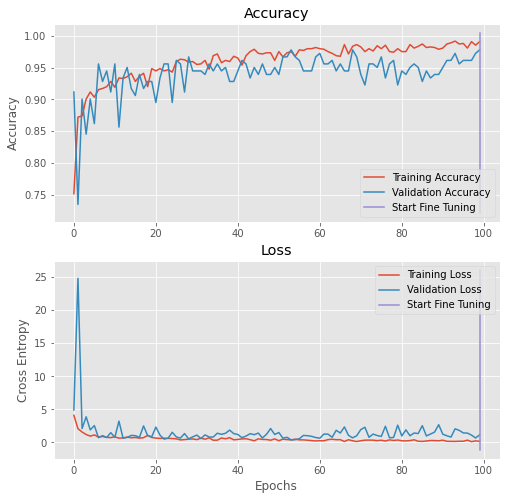

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 0.5149 - accuracy: 0.9766

2/5 [===========>..................] - ETA: 2s - loss: 1.2045 - accuracy: 0.9570

3/5 [=================>............] - ETA: 2s - loss: 1.0646 - accuracy: 0.9583

4/5 [=======================>......] - ETA: 1s - loss: 0.8586 - accuracy: 0.9648

5/5 [==============================] - ETA: 0s - loss: 0.9571 - accuracy: 0.9633

5/5 [==============================] - 9s 2s/step - loss: 0.9571 - accuracy: 0.9633


[0.9571134448051453, 0.963302731513977]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

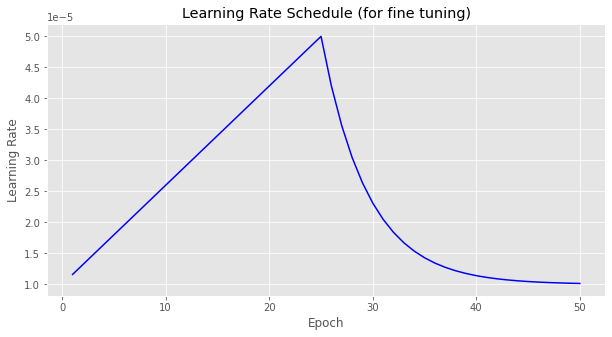

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1087 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8823 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.5529 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 7s - loss: 0.3686 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 9s - loss: 0.3148 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.2519 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.2099 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.2046 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 10s - loss: 0.2264 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 9s - loss: 0.2013 - accuracy: 0.9913 

10/17 [================>.............] - ETA: 8s - loss: 0.3235 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 7s - loss: 0.2959 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 6s - loss: 0.3043 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 4s - loss: 0.3220 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.2990 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2790 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2842 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.9880

17/17 [==============================] - 22s 1s/step - loss: 0.2677 - accuracy: 0.9880 - val_loss: 1.0280 - val_accuracy: 0.9779



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5182 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 15s - loss: 0.3477 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.4400 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 16s - loss: 0.3473 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.4022 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 14s - loss: 0.3352 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.2924 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 15s - loss: 0.2559 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.3793 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.3495 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 10s - loss: 0.3250 - accuracy: 0.9830

12/17 [====================>.........] - ETA: 7s - loss: 0.2986 - accuracy: 0.9844 

13/17 [=====================>........] - ETA: 5s - loss: 0.3591 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.3334 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.3112 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.9862

17/17 [==============================] - 25s 1s/step - loss: 0.2776 - accuracy: 0.9862 - val_loss: 0.9347 - val_accuracy: 0.9779



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3501 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 20s - loss: 0.2715 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 21s - loss: 0.1810 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.1358 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 17s - loss: 0.1345 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1482 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 11s - loss: 0.2021 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 12s - loss: 0.1768 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.1572 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1415 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1618 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1483 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1656 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.1538 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2192 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2260 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.2129 - accuracy: 0.9853 - val_loss: 0.8707 - val_accuracy: 0.9834



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 5.0291e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.2107 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 17s - loss: 0.1996 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.1497 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.1197 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1393 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1194 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1076 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.1384 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1409 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 10s - loss: 0.1281 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.1423 - accuracy: 0.9883 

13/17 [=====================>........] - ETA: 5s - loss: 0.1406 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1305 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1218 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1441 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9890

17/17 [==============================] - 25s 1s/step - loss: 0.1357 - accuracy: 0.9890 - val_loss: 0.8269 - val_accuracy: 0.9834



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 5.5879e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.1888 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 22s - loss: 0.5046 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 18s - loss: 0.4605 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 17s - loss: 0.3881 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 18s - loss: 0.3234 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.3801 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 15s - loss: 0.4154 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 12s - loss: 0.3692 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.3324 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.3022 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2918 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2695 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2503 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2691 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2524 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.2495 - accuracy: 0.9871 - val_loss: 0.7775 - val_accuracy: 0.9834



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 2.6263e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.4132 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 14s - loss: 0.2938 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.2211 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.1769 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 16s - loss: 0.1403 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.1783 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.1731 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1558 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1442 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1321 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1328 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1233 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1216 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1145 - accuracy: 0.9899 - val_loss: 0.7478 - val_accuracy: 0.9834



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 6.5591e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 3.2840e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 8s - loss: 0.1142 - accuracy: 0.9896    

 4/17 [======>.......................] - ETA: 10s - loss: 0.0857 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 10s - loss: 0.2321 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 12s - loss: 0.1988 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 10s - loss: 0.2252 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 11s - loss: 0.1971 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 9s - loss: 0.1752 - accuracy: 0.9913 

10/17 [================>.............] - ETA: 8s - loss: 0.1577 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 7s - loss: 0.1498 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.1373 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 4s - loss: 0.1278 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1307 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1410 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1499 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9871

17/17 [==============================] - 22s 1s/step - loss: 0.1628 - accuracy: 0.9871 - val_loss: 0.7160 - val_accuracy: 0.9834



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0451 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.4503 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 11s - loss: 0.3002 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 11s - loss: 0.3155 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 15s - loss: 0.3208 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 12s - loss: 0.3294 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 16s - loss: 0.2824 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 14s - loss: 0.2471 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 13s - loss: 0.2196 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1978 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1798 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1690 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1560 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1449 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1352 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1268 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9917

17/17 [==============================] - 24s 1s/step - loss: 0.1194 - accuracy: 0.9917 - val_loss: 0.6886 - val_accuracy: 0.9834



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4257 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.3569 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 10s - loss: 0.2780 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 14s - loss: 0.2085 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.2429 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 16s - loss: 0.2541 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.2893 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 11s - loss: 0.2571 - accuracy: 0.9809

10/17 [================>.............] - ETA: 10s - loss: 0.2560 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2327 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2133 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1969 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.1828 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1751 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1780 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9844

17/17 [==============================] - 23s 1s/step - loss: 0.1896 - accuracy: 0.9844 - val_loss: 0.6607 - val_accuracy: 0.9834



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2295 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 19s - loss: 0.2097 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 15s - loss: 0.1398 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 12s - loss: 0.1048 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.1580 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.1316 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 12s - loss: 0.1128 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1321 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.1241 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1248 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1134 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1311 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1214 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1144 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1080 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1014 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.0956 - accuracy: 0.9890 - val_loss: 0.6423 - val_accuracy: 0.9779



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1247 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 7s - loss: 0.0879 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.1202 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.0902 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1376 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1412 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.1210 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1059 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.0941 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0985 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.0906 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.0837 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0852 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.0990 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1297 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1222 - accuracy: 0.9899 - val_loss: 0.6355 - val_accuracy: 0.9779



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5258 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 14s - loss: 0.4523 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 19s - loss: 0.3015 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.2261 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 20s - loss: 0.1809 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.2123 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 13s - loss: 0.1820 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1592 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1480 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1652 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1502 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1376 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1271 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1180 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1199 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1124 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1267 - accuracy: 0.9899 - val_loss: 0.6258 - val_accuracy: 0.9779



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 1.4967 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.7893 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 24s - loss: 0.6140 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 22s - loss: 0.4605 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.4128 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.3793 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.3513 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.3255 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.3158 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.3101 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2828 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2594 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2897 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2897 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2704 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2535 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.2388 - accuracy: 0.9880 - val_loss: 0.6187 - val_accuracy: 0.9724



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 7.4506e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 17s - loss: 0.1511 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 21s - loss: 0.1008 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.0976 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.0781 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1189 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.2214 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 16s - loss: 0.2012 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.1897 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.1775 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.1750 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2315 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2505 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2402 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2241 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2101 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.1980 - accuracy: 0.9862 - val_loss: 0.6130 - val_accuracy: 0.9724



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 4.0769e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.0049 - accuracy: 1.0000   

 3/17 [====>.........................] - ETA: 25s - loss: 0.0033 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 21s - loss: 0.0364 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0557 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0470 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0403 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.0453 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0408 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0904 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0828 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 6s - loss: 0.0765 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0732 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0693 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0833 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9908

17/17 [==============================] - 25s 1s/step - loss: 0.0880 - accuracy: 0.9908 - val_loss: 0.6041 - val_accuracy: 0.9724



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8492 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 10s - loss: 0.4246 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.4667 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.3521 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.2822 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.2734 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.2589 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.2283 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 13s - loss: 0.2031 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1904 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1731 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2554 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2358 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2500 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2379 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2230 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.2101 - accuracy: 0.9862 - val_loss: 0.6034 - val_accuracy: 0.9779



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3291 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.1845 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.1230 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 19s - loss: 0.0923 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.0738 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.0615 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0730 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.1335 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1864 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1678 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1767 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1723 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1595 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1577 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1711 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1753 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.1769 - accuracy: 0.9871 - val_loss: 0.6056 - val_accuracy: 0.9779



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7037 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.3518 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.2346 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 18s - loss: 0.1759 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.1632 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.1360 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.2210 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.2770 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.3284 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.3617 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.3940 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.3631 - accuracy: 0.9805

13/17 [=====================>........] - ETA: 5s - loss: 0.3351 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.3113 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2905 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2816 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.9834

17/17 [==============================] - 24s 1s/step - loss: 0.2652 - accuracy: 0.9834 - val_loss: 0.6048 - val_accuracy: 0.9779



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 3.2425e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 1.6212e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 1.6020e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 10s - loss: 1.2020e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 14s - loss: 0.0503 - accuracy: 0.9937    

 6/17 [=========>....................] - ETA: 11s - loss: 0.0793 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 11s - loss: 0.2117 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.1950 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.1994 - accuracy: 0.9878

10/17 [================>.............] - ETA: 8s - loss: 0.1799 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 7s - loss: 0.1884 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 5s - loss: 0.3154 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 4s - loss: 0.3142 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 3s - loss: 0.2918 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2724 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2676 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9862

17/17 [==============================] - 21s 1s/step - loss: 0.2521 - accuracy: 0.9862 - val_loss: 0.5980 - val_accuracy: 0.9779



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.0138 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 19s - loss: 0.0092 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.0378 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 17s - loss: 0.0530 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.1357 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.1179 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1334 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1186 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1073 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1149 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1059 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1139 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1168 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1090 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1022 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.1290 - accuracy: 0.9871 - val_loss: 0.5956 - val_accuracy: 0.9779



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 2.2724e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 1.5887e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 10s - loss: 0.0257 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 10s - loss: 0.0214 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0171 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 11s - loss: 0.0311 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.0318 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 11s - loss: 0.0279 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0767 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0908 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.1556 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1428 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1318 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1224 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1249 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1472 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9899

17/17 [==============================] - 22s 1s/step - loss: 0.1810 - accuracy: 0.9899 - val_loss: 0.5883 - val_accuracy: 0.9779



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4442 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 9s - loss: 0.2221 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.1481 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 15s - loss: 0.1111 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.1527 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.1272 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.1091 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.1339 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1201 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1903 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1730 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1586 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1847 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1715 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1601 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1500 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9917

17/17 [==============================] - 23s 1s/step - loss: 0.1414 - accuracy: 0.9917 - val_loss: 0.5877 - val_accuracy: 0.9779



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.3272 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.2181 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.2903 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 20s - loss: 0.2495 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 17s - loss: 0.2079 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.1799 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.2456 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.2474 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2234 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2315 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2557 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2808 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2907 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2713 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2670 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.2695 - accuracy: 0.9862 - val_loss: 0.5916 - val_accuracy: 0.9779



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 0.9396 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 4s - loss: 0.6949 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 16s - loss: 0.4967 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 14s - loss: 0.4288 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 17s - loss: 0.3431 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.2859 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.3010 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.3014 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 10s - loss: 0.2748 - accuracy: 0.9844

10/17 [================>.............] - ETA: 9s - loss: 0.2727 - accuracy: 0.9828 

11/17 [==================>...........] - ETA: 7s - loss: 0.2485 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 6s - loss: 0.2278 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2110 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.1960 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1829 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1715 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1629 - accuracy: 0.9890 - val_loss: 0.5950 - val_accuracy: 0.9779



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 2.5085e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0308 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 21s - loss: 0.1168 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 24s - loss: 0.0876 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 21s - loss: 0.1019 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 17s - loss: 0.0849 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.0729 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.2189 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 11s - loss: 0.2970 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2676 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 10s - loss: 0.2432 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 7s - loss: 0.2510 - accuracy: 0.9870 

13/17 [=====================>........] - ETA: 5s - loss: 0.2445 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2304 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2150 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2209 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.9871

17/17 [==============================] - 25s 1s/step - loss: 0.2365 - accuracy: 0.9871 - val_loss: 0.5972 - val_accuracy: 0.9779



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2673 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.1336 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0891 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.3489 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.2952 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2670 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.2288 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 12s - loss: 0.2002 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1780 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.1602 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.1740 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.1595 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1730 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1861 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1737 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1628 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.9917

17/17 [==============================] - 23s 1s/step - loss: 0.1534 - accuracy: 0.9917 - val_loss: 0.6005 - val_accuracy: 0.9724



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3337 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.2606 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 22s - loss: 0.2446 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 19s - loss: 0.1834 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.1550 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 16s - loss: 0.1607 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.1378 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1343 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.1756 - accuracy: 0.9844

10/17 [================>.............] - ETA: 10s - loss: 0.2058 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.1871 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2274 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2111 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.1960 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2116 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2049 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.1930 - accuracy: 0.9853 - val_loss: 0.5939 - val_accuracy: 0.9724



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 1.7459e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 12s - loss: 0.1742 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 20s - loss: 0.1313 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.2591 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 17s - loss: 0.2159 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.2317 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.2084 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1909 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1718 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1562 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1432 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1322 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1444 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1421 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1437 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1355 - accuracy: 0.9890 - val_loss: 0.5951 - val_accuracy: 0.9724



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3200 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.1600 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 15s - loss: 0.1068 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.2713 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.2171 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.1809 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.1576 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.2360 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.2097 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1889 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1717 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.2251 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2168 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.2321 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2201 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2064 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1944 - accuracy: 0.9890 - val_loss: 0.5942 - val_accuracy: 0.9724



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.6983 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 18s - loss: 0.3493 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.2364 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 23s - loss: 0.2049 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.1651 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1388 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1190 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1399 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.2252 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.2027 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1846 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1847 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1705 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1584 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1479 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1386 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9936

17/17 [==============================] - 24s 1s/step - loss: 0.1306 - accuracy: 0.9936 - val_loss: 0.5935 - val_accuracy: 0.9724



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2552 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.1276 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0865 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0676 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.0541 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 14s - loss: 0.0488 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0366 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.0325 - accuracy: 0.9965

10/17 [================>.............] - ETA: 11s - loss: 0.0293 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 9s - loss: 0.0266 - accuracy: 0.9972 

12/17 [====================>.........] - ETA: 7s - loss: 0.0244 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 5s - loss: 0.0348 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 4s - loss: 0.0455 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0425 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0398 - accuracy: 0.9961

17/17 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9963

17/17 [==============================] - 24s 1s/step - loss: 0.0375 - accuracy: 0.9963 - val_loss: 0.5946 - val_accuracy: 0.9724



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 0.0424 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 15s - loss: 0.0318 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 21s - loss: 0.0254 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 19s - loss: 0.0212 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 18s - loss: 0.0182 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 16s - loss: 0.2372 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.2043 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 10s - loss: 0.1857 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 8s - loss: 0.1873 - accuracy: 0.9896 

13/17 [=====================>........] - ETA: 6s - loss: 0.1896 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1771 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1653 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1550 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9908

17/17 [==============================] - 25s 1s/step - loss: 0.1462 - accuracy: 0.9908 - val_loss: 0.5976 - val_accuracy: 0.9724



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2939 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.6105 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 20s - loss: 0.4448 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 16s - loss: 0.3336 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.4526 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 12s - loss: 0.4010 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 16s - loss: 0.3811 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 14s - loss: 0.3335 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.2964 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.2982 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.2711 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2530 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2339 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.2172 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2028 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1901 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9917

17/17 [==============================] - 23s 1s/step - loss: 0.1791 - accuracy: 0.9917 - val_loss: 0.6001 - val_accuracy: 0.9724



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.0134 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0090 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.1516 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 20s - loss: 0.1584 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.2206 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.2035 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 13s - loss: 0.1809 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.4775 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.4342 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.4087 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.4191 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.4099 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.3826 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.3586 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.3379 - accuracy: 0.9853 - val_loss: 0.6012 - val_accuracy: 0.9724



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 2.4131e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 2.6644e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 1.7772e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 0.0432 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 18s - loss: 0.0346 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.0764 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.0655 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0671 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.1195 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1076 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0896 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0827 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.0974 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0909 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0852 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9908

17/17 [==============================] - 23s 1s/step - loss: 0.0825 - accuracy: 0.9908 - val_loss: 0.6011 - val_accuracy: 0.9724



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1602 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.0405 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 20s - loss: 0.0435 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 19s - loss: 0.0362 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0396 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.0346 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.0308 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0277 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0500 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0542 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0500 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0484 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0452 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0432 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.0516 - accuracy: 0.9926 - val_loss: 0.6073 - val_accuracy: 0.9724



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.2037 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 12s - loss: 0.1977 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.3372 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 18s - loss: 0.2996 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 15s - loss: 0.2755 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 12s - loss: 0.2713 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 12s - loss: 0.2658 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 11s - loss: 0.2708 - accuracy: 0.9774

10/17 [================>.............] - ETA: 9s - loss: 0.2438 - accuracy: 0.9797 

11/17 [==================>...........] - ETA: 8s - loss: 0.2356 - accuracy: 0.9801

12/17 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2207 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 3s - loss: 0.2141 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.1999 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.1874 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.1766 - accuracy: 0.9853 - val_loss: 0.6136 - val_accuracy: 0.9724



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4424 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 13s - loss: 0.2212 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.1475 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 18s - loss: 0.1631 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.1305 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.1120 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1176 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1310 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 10s - loss: 0.1164 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.1048 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 7s - loss: 0.1050 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1299 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2094 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 3s - loss: 0.1981 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.1866 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.1880 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.1771 - accuracy: 0.9853 - val_loss: 0.6075 - val_accuracy: 0.9724



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0651 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.0595 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.1830 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 12s - loss: 0.1785 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.2352 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 13s - loss: 0.1960 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.2109 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.1846 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.1643 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1479 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1344 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1232 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1137 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1056 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0986 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0924 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.1110 - accuracy: 0.9908 - val_loss: 0.5994 - val_accuracy: 0.9724



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0522 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.0261 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.1703 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 17s - loss: 0.1277 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.2116 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 13s - loss: 0.1763 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 16s - loss: 0.1539 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.1346 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.1197 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1077 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1015 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.0931 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.0993 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1127 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1052 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.0997 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1223 - accuracy: 0.9890 - val_loss: 0.6020 - val_accuracy: 0.9724



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5188 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.4942 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 19s - loss: 0.3669 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 17s - loss: 0.3730 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.2984 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2527 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.2301 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.2013 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1790 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1611 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 8s - loss: 0.1464 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1342 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1931 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1848 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1725 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1886 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.1792 - accuracy: 0.9862 - val_loss: 0.6030 - val_accuracy: 0.9724



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 1.8626e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 0.0799 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 21s - loss: 0.1631 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.1305 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2141 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.1835 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.2627 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2407 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2505 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.2278 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2088 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.1931 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1793 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1744 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1636 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1541 - accuracy: 0.9890 - val_loss: 0.5994 - val_accuracy: 0.9724



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 20s - loss: 6.2088e-10 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 17s - loss: 2.6672e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 15s - loss: 2.1339e-05 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 14s - loss: 0.1216 - accuracy: 0.9922    

 7/17 [===========>..................] - ETA: 17s - loss: 0.1042 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.0912 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.0982 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0884 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 8s - loss: 0.0989 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 6s - loss: 0.1361 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1269 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1199 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1444 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9899

17/17 [==============================] - 25s 1s/step - loss: 0.1360 - accuracy: 0.9899 - val_loss: 0.5927 - val_accuracy: 0.9724



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0407 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 20s - loss: 0.1008 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 20s - loss: 0.1862 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 22s - loss: 0.1646 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 20s - loss: 0.1372 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 18s - loss: 0.1176 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.2012 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 13s - loss: 0.1788 - accuracy: 0.9826

10/17 [================>.............] - ETA: 10s - loss: 0.1610 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.1465 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1343 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1240 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1392 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1299 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1392 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1311 - accuracy: 0.9890 - val_loss: 0.5873 - val_accuracy: 0.9724



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 9.3132e-10 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 6.2088e-10 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 16s - loss: 0.0539 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 18s - loss: 0.0432 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 19s - loss: 0.0644 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0552 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 14s - loss: 0.0998 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1144 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1031 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0937 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0859 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.1342 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.1246 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.1356 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1377 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1810 - accuracy: 0.9926 - val_loss: 0.5865 - val_accuracy: 0.9724



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 4.2127e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 5.3393e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 3.5596e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 2.8272e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 18s - loss: 2.2622e-04 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 15s - loss: 1.8851e-04 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9978    

 8/17 [=============>................] - ETA: 14s - loss: 0.1251 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.1112 - accuracy: 0.9965

10/17 [================>.............] - ETA: 11s - loss: 0.1001 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 9s - loss: 0.0910 - accuracy: 0.9972 

12/17 [====================>.........] - ETA: 7s - loss: 0.0834 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 5s - loss: 0.0770 - accuracy: 0.9976

14/17 [=======================>......] - ETA: 4s - loss: 0.0717 - accuracy: 0.9978

15/17 [=========================>....] - ETA: 2s - loss: 0.0669 - accuracy: 0.9979

16/17 [===========================>..] - ETA: 1s - loss: 0.0641 - accuracy: 0.9971

17/17 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9954

17/17 [==============================] - 24s 1s/step - loss: 0.0811 - accuracy: 0.9954 - val_loss: 0.5864 - val_accuracy: 0.9724



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7289 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 11s - loss: 0.5167 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 17s - loss: 0.3445 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.2583 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.2491 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 15s - loss: 0.2076 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1779 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1557 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1384 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1268 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1154 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1132 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1150 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1615 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1636 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1534 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.1597 - accuracy: 0.9853 - val_loss: 0.5905 - val_accuracy: 0.9724



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 6.2088e-10 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 14s - loss: 0.0767 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0993 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 13s - loss: 0.0851 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.0755 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1054 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.0948 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.0862 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0797 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1030 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1313 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1225 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1149 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1390 - accuracy: 0.9890 - val_loss: 0.5957 - val_accuracy: 0.9724



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.0806 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 11s - loss: 0.0537 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.0686 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.0548 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0595 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.0924 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.0934 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1342 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1272 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1258 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1153 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1330 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.1235 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1153 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9871

17/17 [==============================] - 23s 1s/step - loss: 0.1187 - accuracy: 0.9871 - val_loss: 0.5954 - val_accuracy: 0.9724



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 7.6925e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 0.1035 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 20s - loss: 0.0690 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 19s - loss: 0.0604 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.0483 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0838 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.0719 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.0752 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1073 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.0965 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1428 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1309 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1208 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1122 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1048 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1216 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9899

17/17 [==============================] - 23s 1s/step - loss: 0.1168 - accuracy: 0.9899 - val_loss: 0.5919 - val_accuracy: 0.9724


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

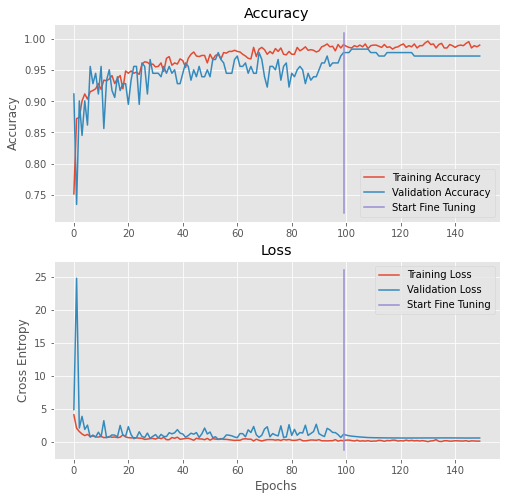

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.3002 - accuracy: 0.9453

2/5 [===========>..................] - ETA: 2s - loss: 1.5108 - accuracy: 0.9531

3/5 [=================>............] - ETA: 2s - loss: 1.0341 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 0.7763 - accuracy: 0.9727

5/5 [==============================] - ETA: 0s - loss: 0.7757 - accuracy: 0.9725

5/5 [==============================] - 6s 1s/step - loss: 0.7757 - accuracy: 0.9725


[0.7757061123847961, 0.9724770784378052]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9724770642201835
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       158
           1       0.97      0.99      0.98       387

    accuracy                           0.97       545
   macro avg       0.97      0.96      0.97       545
weighted avg       0.97      0.97      0.97       545



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

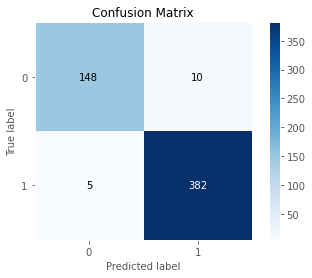

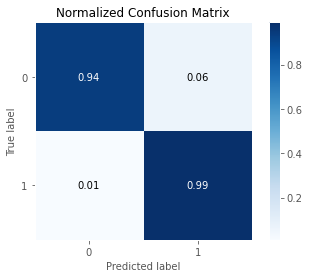

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

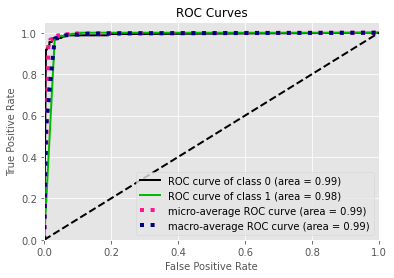

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       158
           1       0.97      0.99      0.98       387

    accuracy                           0.97       545
   macro avg       0.97      0.96      0.97       545
weighted avg       0.97      0.97      0.97       545

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.94      0.99      0.95      0.96      0.92       158
          1       0.97      0.99      0.94      0.98      0.96      0.93       387

avg / total       0.97      0.97      0.95      0.97      0.96      0.93       545

